In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
from skimage.measure import shannon_entropy as entropy
from tqdm import tqdm
from scipy.io import savemat
import os
from pathlib import Path

from rle import *


In [4]:
def plot_latent_distributions(
        filepath="/scratch/zb7df/data/latents/latent_tensors.h5"
):
    with h5py.File(filepath, 'r') as f:
        y_hat = f['y_hat'][:]
        z_hat = f["z_hat"][:]
        print(f"y_hat: {type(y_hat)} | {y_hat.shape}")
        print(f"z_hat: {type(z_hat)} | {z_hat.shape}")

    # Overall distribution
    plt.figure(figsize=(6, 4))

    # Plot y_hat distribution
    # len(np.unique(y_hat))
    plt.hist(y_hat.flatten(), bins=100, density=True)
    plt.title('Overall Y-hat Distribution')
    plt.xlabel('Value')
    plt.ylabel('Density')
    
    plt.tight_layout()
    plt.show()

    print("\nOverall Y-hat statistics:")
    print(f"Mean: {np.mean(y_hat):.4f}")
    print(f"Std: {np.std(y_hat):.4f}")
    print(f"Distinct: {len(np.unique(y_hat))}")
    print(f"Equal zero: {100 * np.mean(y_hat == 0):.2f}%")
    print(f"Entropy: {entropy(y_hat):.4f}")

    return y_hat, z_hat


y_hat: <class 'numpy.ndarray'> | (10, 320, 16, 16)
z_hat: <class 'numpy.ndarray'> | (10, 192, 4, 4)


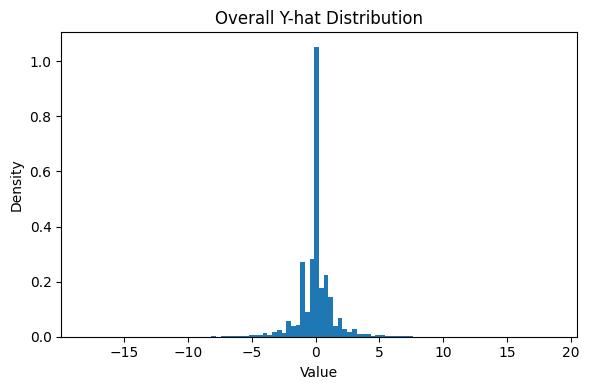


Overall Y-hat statistics:
Mean: 0.0215
Std: 1.4461
Distinct: 815438
Equal zero: 0.00%
Entropy: 19.6346


In [5]:
y_hat, z_hat = plot_latent_distributions()

y_hat: <class 'numpy.ndarray'> | (10, 320, 16, 16)
z_hat: <class 'numpy.ndarray'> | (10, 192, 4, 4)


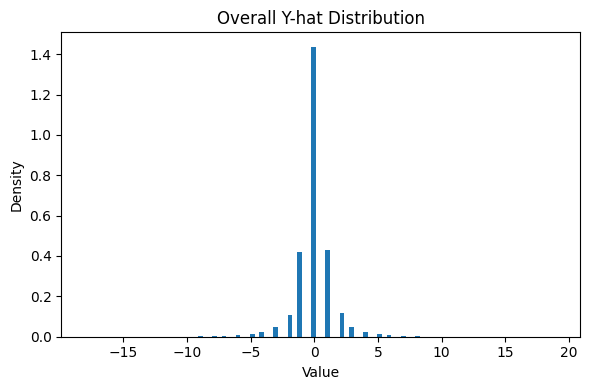


Overall Y-hat statistics:
Mean: 0.0097
Std: 1.4499
Distinct: 36
Equal zero: 53.14%
Entropy: 2.2088


In [6]:
filepath="/scratch/zb7df/data/latents/latent_tensors_bypass.h5"
y_hat_b, z_hat_b = plot_latent_distributions(filepath)

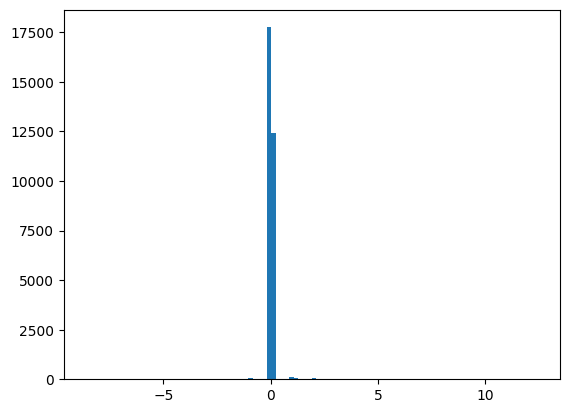

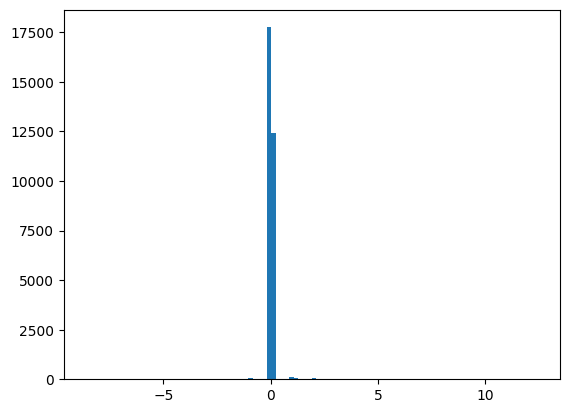

In [ ]:
plt.hist(z_hat.flatten(), bins=100)
plt.show()

100%|██████████| 320/320 [00:03<00:00, 105.63it/s]


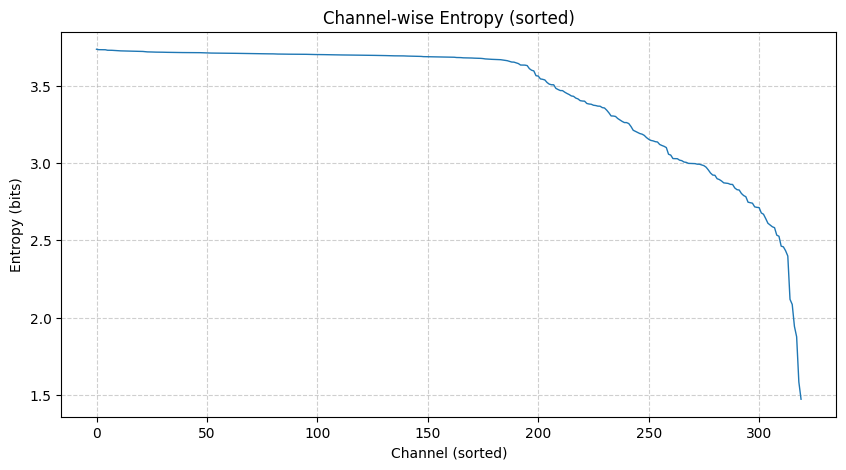

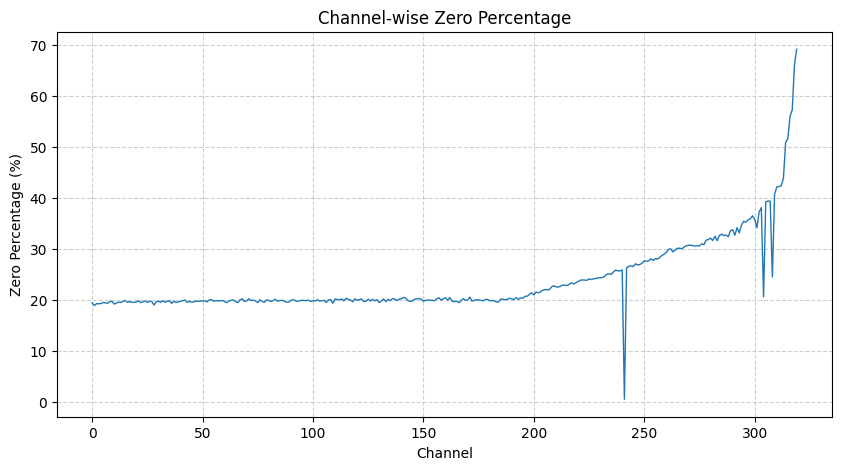

In [ ]:
N, C, H, W = y_hat.shape

entropies = []
zero_props = []
for c in tqdm(range(C)):
    channel_data = y_hat[:, c, :, :].ravel()
    entropies.append(entropy(channel_data))
    zero_props.append(np.mean(channel_data == 0)*100)

# Sort entropies in descending order
entropies = np.array(entropies)
zero_props = np.array(zero_props)
sorted_indices = np.argsort(-entropies)
entropies_sorted = entropies[sorted_indices]
zero_props_sorted = zero_props[sorted_indices]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(entropies_sorted, linewidth=1)
plt.title("Channel-wise Entropy (sorted)")
plt.xlabel("Channel (sorted)")
plt.ylabel("Entropy (bits)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(zero_props_sorted, linewidth=1)
plt.title("Channel-wise Zero Percentage")
plt.xlabel("Channel")
plt.ylabel("Zero Percentage (%)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [19]:
z_hat.shape

(10, 192, 4, 4)

In [16]:
data = {"y_hat_elic": y_hat, "y_hat_bypass": y_hat_b, "z_hat": z_hat}
savemat("/scratch/zb7df/data/latents/latent_tensors.mat", data)

In [5]:
orig_bits = []
compressed_bits = []
for img in tqdm(y_hat[:10]):
    orig_shape = img.shape
    arr = img.squeeze().ravel()

    # Encode arr with RLE
    vals, lens = rle_encode(arr)

    # Encode RLE with Exp-Golomb
    vals_encoded = exp_golomb_encode(vals)
    lens_encoded = exp_golomb_encode(lens)

    # Decode RLE
    vals_decoded = exp_golomb_decode(vals_encoded)
    lens_decoded = exp_golomb_decode(lens_encoded)

    # Decode arr
    arr_decoded = rle_decode(vals_decoded, lens_decoded)

    orig_bits.append(calc_orig_bits(arr))
    compressed_bits.append(len(vals_encoded) + len(lens_encoded))

100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


# Calculate Results

In [4]:
base_path = Path("/scratch/zb7df/data/results")
# files = ["HH_bypass12_1.csv", "HH_bypass123_1.csv", 
#          "HH_bypass1234_1.csv", "HH_bypass12345_1.csv"]
files = ["HH_bypass0_1.csv"]

means_list = []
for file in files:
    df = pd.read_csv(base_path / file, header=0)
    means = df.iloc[:, 1:].mean()
    means_list.append(means)

col = ["bpp", "psnr", "ssim", "sqnr", "mape_phase", "enc_time", "dec_time"]
results_df = pd.DataFrame(means_list, index=[f.split('.')[0] for f in files], columns=col)
results_df["tot_time"] = results_df["enc_time"] + results_df["dec_time"]
results_df["bpp_reduction"] = 1 - (results_df["bpp"] / 32)

results_df

,bpp,psnr,ssim,sqnr,mape_phase,enc_time,dec_time,tot_time,bpp_reduction
HH_bypass0_1,1.167086,28.176845,0.961492,15.289758,0.520727,0.13915,0.085877,0.225027,0.963529


# TO DO
### Calculate BPP, PSNR, Enc_Time, Dec_Time per channel/channel group for Baseline vs. Bypass
### Find channels/groups where Bypass has larger effect
### Bypass those channels/groups and not the others